# Trabalho Prático 01 (Detecção de Alvos Planos)
- Giovanna Louzi Bellonia
- Thiago Martin Poppe
<br><br>

__Obs.:__ Cada função possui uma descrição em Markdown e uma docstring contendo uma descrição breve, parâmetros (tipos e o que significam) e retorno.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lendo o vídeo e salvando os frames em um numpy.array

In [2]:
# Lendo o vídeo
cap = cv2.VideoCapture('entrada.avi')

# Salvando os frames para um numpy array
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        print('*** Capture Finished ***')
        break
        
    frames.append(frame)

frames = np.array(frames)

*** Capture Finished ***


## Função show

- A função ___show___ foi definida para que pudessemos ver as imagens na célula do notebook sem que precisarmos abrir a janela extra do OpenCV, facilitando os testes e análises.

In [3]:
def show(img):
    """
        Exibe uma imagem, na própria célula, usando matplotlib
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem a ser exibida
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

# Função is_in

- A função ___is_in___ verifica se algum ponto na vizinhança do ponto (x, y) é uma quina.
- O tamanho da vizinhança a ser analisada é passado para a função através do parâmetro _offset_. Note que serão _offset_ pixels à esquerda e à direita do ponto escolhido!

In [4]:
def is_in(x, y, offset, corners):
    """
        Verifica se existe alguma quina em volta de um dado ponto
        
        Parâmetros
        ----------
        x : int
            Valor da coordenada x do ponto
        
        y : int
            Valor da coordenada y do ponto
            
        offset : int
            Offset a ser usado para olhar ao redor do ponto
        
         corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        Retorno
        -------
        tuple
            Se uma quina for encontrada, retorna a sua posição em uma tupla.
            Caso contrário, retorna a tupla (-1, -1)
    """
    
    for i in range(x - offset, x + offset + 1):
        for j in range(y - offset, y + offset + 1):
            if (i,j) in corners:
                return (i,j)
    return (-1,-1)

# Passo a passo do algoritmo:

## 1) Encontrando os pontos de quina

- Primeiramente, convertemos o frame atual para tons de cinza. Em seguida realizamos o seguinte procedimento:
    - Utilizamos o Harris Corner Detector, para detectar as quinas na nossa cena.
    - Filtramos as quinas deixando aquelas que são maiores que 20% da intensidade do valor máximo encontrado.
    - Calculamos o índice (i,j) de cada quina na imagem, salvando em uma lista chamada _corners_.
    - Pintamos de vermelho na imagem as quinas filtradas, e exibimos.

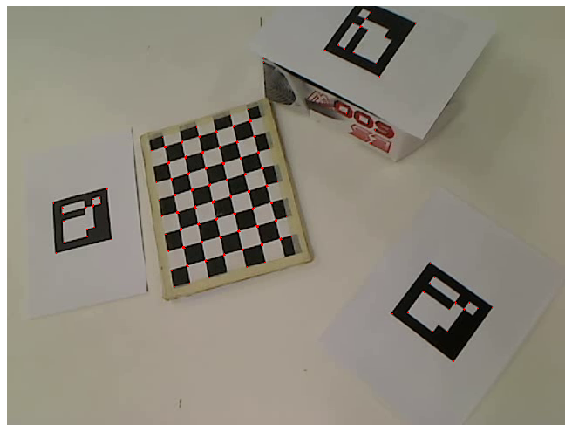

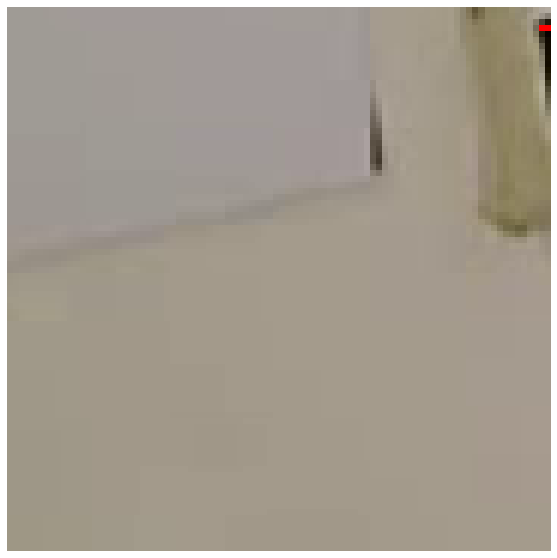

In [127]:
# Selecionando o primeiro frame
frame = frames[374].copy()

# Passando o frame escolhido para tons de cinza
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Aplicando Harris para detecção de quinas
gray = np.float32(gray)
harris = cv2.cornerHarris(gray, 2, 3, 0.04) 

# Extraindo pontos de quina
pts = harris > 0.15 * harris.max()
corners = [tuple((y, x)) for x,y in np.argwhere(pts == True)]

# Exibindo em vermelho os pontos de quina
img = frame.copy()
img[pts] = [0, 0, 255]

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
show(cv2.cvtColor(img[300:390, 100:190], cv2.COLOR_BGR2RGB))

## 2) Encontrando os pontos do alvo

__Obs.:__ Para fins de exemplo, executamos apenas para 1 ponto de quina

- Iremos executar o seguinte algoritmo para cada ponto de quina, até termos 4 pontos:
    - Inserimos o ponto lido na lista de pontos do possível alvo
    - Iremos andar 60 pixels em uma direção definida por um ângulo escolhido
    - Verificamos em torno de uma área em busca de quinas
    - Chamamos a função recursivamente para o novo ponto encontrado
    <br><br>
    
- Explicações sobre os ângulos escolhidos:
    - Sempre iremos percorrer o alvo no sentido anti-horário, logo, para o primeiro ponto iremos verificar possíveis quinas entre 0º e 90º. Para o segundo ponto, iremos verificar possíveis quinas entre 90º e 180º, e assim por diante.

Os pontos são: [(512, 407), (556, 345), (485, 294), (442, 352)]

Imagem da varredura


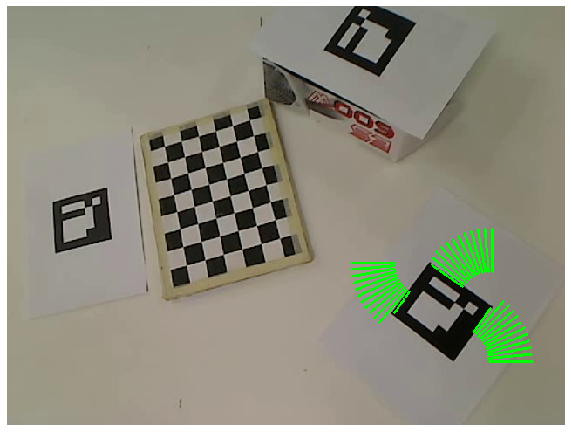


Imagem dos pontos


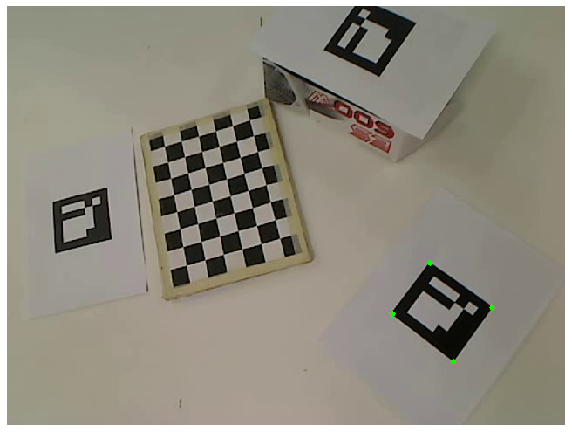

In [132]:
# Pegando o ponto de início e copiando o frame atual
p = corners[-1]
pt_img = frame.copy()
temp = frame.copy()

# Futuramente essa função será a função que usaremos para varrer a imagem em busca dos pontos (função scan)
# Teremos mais explicações sobre a mesma em células futuras
def scan_show(start, angle, corners, pts, start_check=10):
    
    # Adicionando o ponto à lista de pontos
    pts.append((int(start[0]), int(start[1])))
    
    # Iremos executar até termos 4 pontos, já que o alvo é um quadrilátero
    if len(pts) < 4:
        for j in range(angle, angle+91, 5):
            
            # Calculando a matriz de rotação
            rot = np.float32([
                [np.cos(j * np.pi/180), -np.sin(j * np.pi/180)],
                [np.sin(j * np.pi/180),  np.cos(j * np.pi/180)]
            ])

            # Definindo o ponto atual e a direção a ser andada
            current = np.float32([[start[0]], [start[1]]]).T
            direction = np.float32([[1], [0]]).T @ rot
            
            
            
            current += 40 * direction
            for _ in range(50):
                current += direction
                cv2.circle(temp, tuple((int(current[0][0]), int(current[0][1]))), 1, (0,255,0), -1)
                
                # Caso o ponto for quina, chamamos a função recursivamente para aquele ponto
                pt = is_in(int(current[0][0]), int(current[0][1]), 2, corners)
                if pt != (-1,-1):
                    return scan_show(np.float32([pt[0], pt[1]]), angle+90, corners, pts)
    return pts

# Executando a função
pts = []
pts = scan_show(p, 0, corners, pts)

for p in pts:
    cv2.circle(pt_img, p, 3, (0, 255 ,0), -1)

print('Os pontos são:', pts)
print('\nImagem da varredura')
show(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))

print('\nImagem dos pontos')
show(cv2.cvtColor(pt_img, cv2.COLOR_BGR2RGB))

## 3) Aplicando a homografia
__Obs.:__ Percebemos que o .jpg do alvo não era exatamente quadrado. Então, fizemos um crop para que o mesmo ficasse com dimensões de 310x310 pixels.

- Iremos executar o seguinte algoritmo:
    - Lemos o alvo, calculando suas dimensões.
    - Estimamos a matriz de homografia usando o método RANSAC para filtrar erros grosseiros e aplicamos o warpPerspective.
    - Binarizamos o resultado obtido.

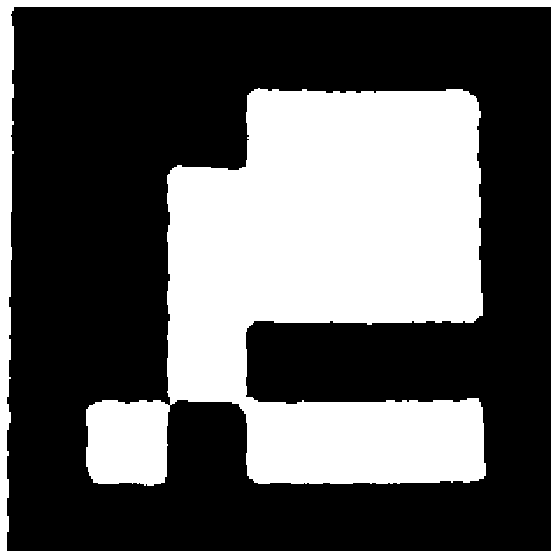

(310, 310)

In [7]:
# Lendo o alvo e obtendo suas dimensões
target = cv2.imread('alvo.jpg')
dim_alvo = np.float32([[0,0], [0, target.shape[1]], [target.shape[0], target.shape[1]], [target.shape[0], 0]])

# Estimando a matriz de homografia e realizando o warpPerspective
M = cv2.findHomography(np.float32(pts), dim_alvo, cv2.RANSAC)[0]
result = cv2.warpPerspective(gray, M, (target.shape[0], target.shape[1]))

# Binarizando o resultado
result[result < 80] = 0
result[result >= 80] = 255

# Exibindo a imagem e as suas dimensões
show(result)
result.shape

## 4) Rotacionando os alvos

- Rotacionamos o alvo em 0º, 90º, 180º e 270º para realizar posteriormente o template matching, pois o alvo pode estar rotacionado na cena.

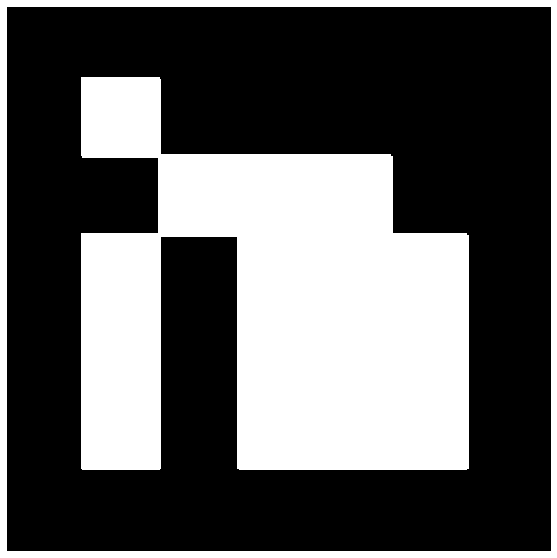

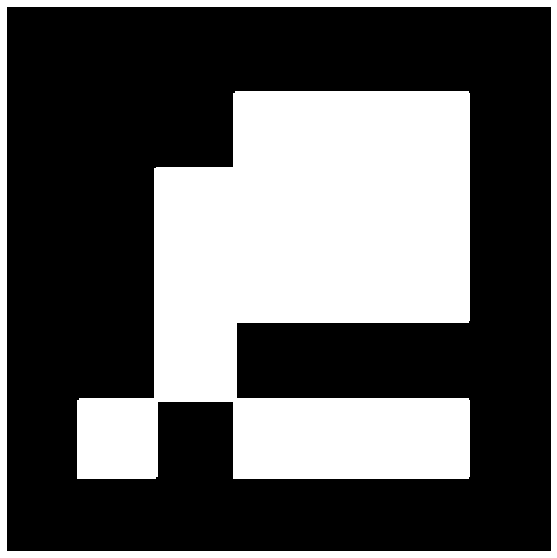

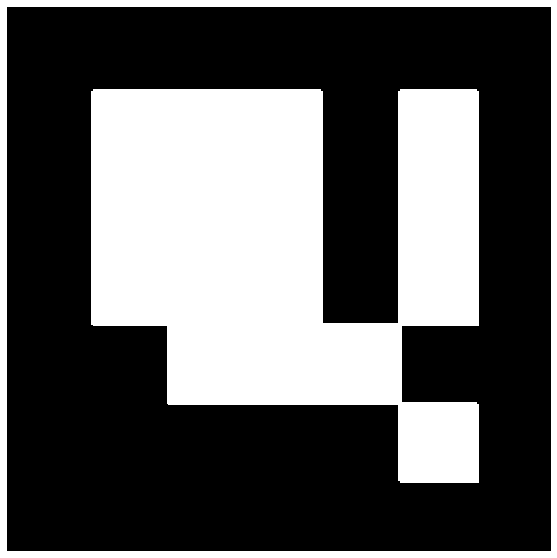

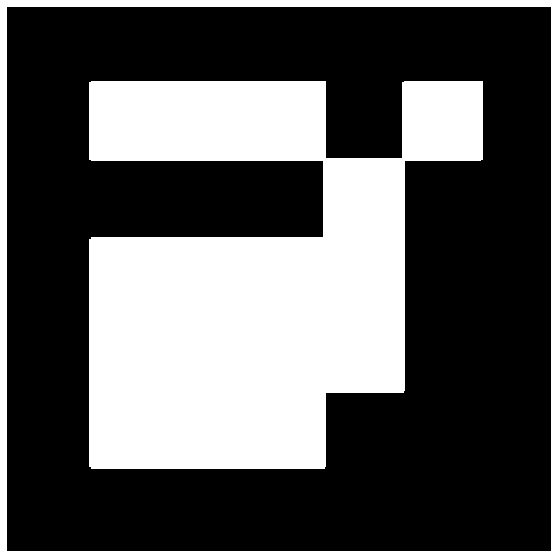

In [8]:
# Convertendo o alvo para tons de cinza e binarizando o mesmo
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
target[target < 25] = 0
target[target >= 25] = 255

# Criando uma lista para os alvos rotacionados
targets = []

# Rotacionando o alvo em cada um dos ângulos e salvando em uma lista
for angle in [0, 90, 180, 270]:
    M = cv2.getRotationMatrix2D((target.shape[1]/2, target.shape[0]/2), angle, 1)
    targets.append(cv2.warpAffine(target, M, (target.shape[0], target.shape[1])))

for target in targets:
    show(target)

## 5) Realizando o template matching

- Realizando o processo de template matching usando a diferença absoluta média dos pixels.
- Caso esse casamento tenha valor menor ou igual à 20, aceitamos como um casamento válido.

In [9]:
for i,target in enumerate(targets):
    match = np.sum(np.abs(target - result)) / (target.size) # Limiar < 20
    if match <= 20:
        print('Casamento bem-sucedido com o alvo rotacionado em', i * 90, 'graus')

Casamento bem-sucedido com o alvo rotacionado em 90 graus


## 6) Colorindo as bordas do alvo

- Borda de cima $\rightarrow$ Azul
- Borda debaixo $\rightarrow$ Vermelha
- Borda da esquerda $\rightarrow$ Verde
- Borda da direita $\rightarrow$ Ciano

__Obs1.:__ Note que devemos para cada rotação do alvo, pintar as bordas em uma ordem diferente!<br>
__Obs2.:__ Temos que informar a cor em BGR devido a OpenCV ser assim.

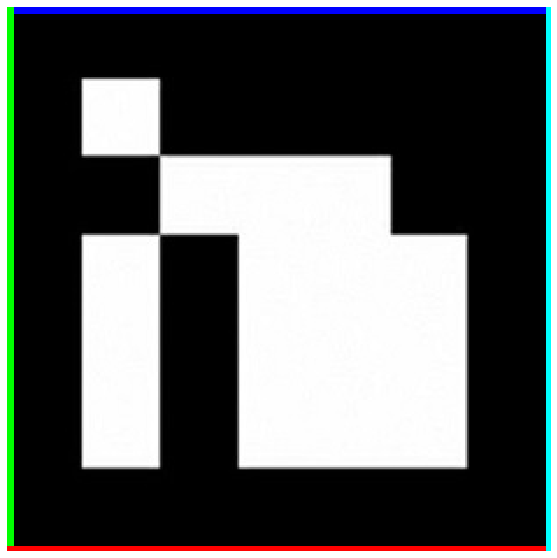

In [10]:
# Lendo novamente o alvo (apenas para exemplo)
target = cv2.imread('alvo.jpg')
img = target.copy()

# Definindo as cores
blue = (255,0,0)
green = (0,255,0)
red = (0,0,255)
cyan = (255,255,0)

# Desenhando as linhas em torno do alvo para exemplificar
cv2.line(img, (0,0), (310,0), blue, 5)
cv2.line(img, (0,0), (0,310), green, 5)
cv2.line(img, (0,310), (310,310), red, 5)
cv2.line(img, (310,310), (310,0), cyan, 5)

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

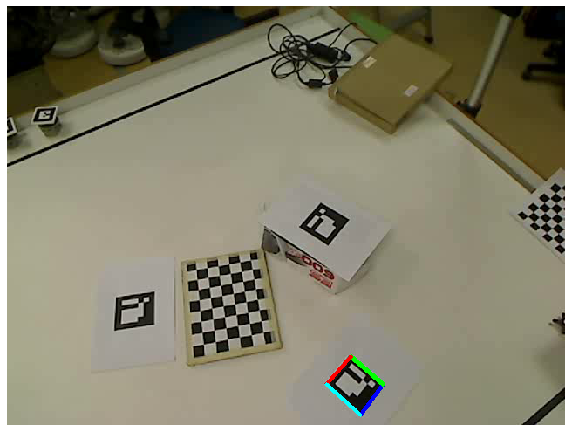

In [11]:
# Desenhando as linhas em torno do alvo na cena
img = frame.copy()
cv2.line(img, pts[0], pts[1], blue, 3)
cv2.line(img, pts[1], pts[2], green, 3)
cv2.line(img, pts[2], pts[3], red, 3)
cv2.line(img, pts[3], pts[0], cyan, 3)

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Resumo do algoritmo e algumas observações

- Agora que já temos todo o pipeline para encontrarmos os alvos em um frame, basta rodarmos o algoritmo para cada frame do vídeo!

- Definiremos a seguir, de forma mais concreta, as funções utilizadas, informando seus parâmetros e valores de retorno (caso tenham).
<br>

- Infelizmente a função ___scan___ não é tão rápida assim... Por isso, criaremos uma função ___scan_optimized___, que dado os pontos onde potencialmente os alvos estão, analisaremos a redondeza desses pontos em busca de pontos de quina. Passaremos os pontos encontrados no frame anterior, visto que a mudança da cena um frame para o outro não é tão brusca.
<br>

- Com isso temos o seguinte algoritmo completo:
    1. Procuramos os alvos na cena utilizando a função ___scan___, que retornará os pontos encontrados.
    2. Para o próximo frame, usaremos os pontos obtidos anteriormente realizando a varredura usando a função ___scan_optimized___.
    3. Caso a função otimizada não retorne 3 conjuntos de pontos (em outras palavras, 3 alvos), devemos executar a ___scan___ na cena.
    4. Fazemos isso até analisarmos todos os frames do vídeo.

In [12]:
def cross(p0, p1):
    return p0[0]*p1[1] - p0[1]*p1[0]

def diff(p0, p1):
    return (p0[0] - p1[0], p0[1] - p1[1])

def right(p0, p1, p):
    return cross(diff(p, p0), diff(p1, p0)) < 0

def out_target(target, p):
    return right(target[0], target[1], p) or \
           right(target[1], target[2], p) or \
           right(target[2], target[3], p) or \
           right(target[3], target[0], p)

In [13]:
def find_corners(frame, harris_tol):
    """
        Encontra as quinas de um dado frame usando o Harris Corner Detector
        
        Parâmetros
        ----------
        frame : numpy.ndarray
            Frame a ser analisado
        
        harris_tol : float
            Tolerância usada para considerar quina
            
        Retorno
        -------
        tuple list
            Uma lista de pontos com as quinas
    """
    
    # Aplicando harris para detecção de quinas
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    harris = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    
    # Extraindo pontos de quina
    pts = harris > harris_tol * harris.max()
    pts_corner = [(y,x) for x,y in np.argwhere(pts == True)]
    
    return pts_corner

In [14]:
def homography(img, src, target):
    """
        Estima e aplica a matriz de homografia em um conjunto de pontos
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem de onde os pontos foram extraídos
            
        src : numpy.ndarray
            Pontos de origem (da imagem)
            
        target : numpy.ndarray
            Pontos do alvo
            
        Retorno
        -------
        numpy.ndarray
            Retorna aquela parte da imagem binarizada e com a homografia aplicada
    """
    
    # Obtendo os pontos no alvo e estimando a matriz de homografia usando RANSAC
    dst = np.float32([[0,0], [0, target.shape[1]], [target.shape[0], target.shape[1]], [target.shape[0], 0]])
    M = cv2.findHomography(src, dst, cv2.RANSAC)[0]
    
    # Aplicando o warpPerspective e binarizando a imagem
    result = cv2.warpPerspective(img, M, (target.shape[0], target.shape[1]))
    result[result < 80] = 0
    result[result >= 80] = 255
    
    return result

In [15]:
def similarity_func(img1, img2):
    """
        Função de similaridade usando a diferença média dos pixels
        
        Parâmetros
        ----------
        img1 : numpy.ndarray
            Imagem 1 a ser comparada
            
        img2 : numpy.ndarray
            Imagem 2 a ser comparada
            
        Retorno
        -------
            Retorna o valor da diferença média dos pixels
    """
    
    return np.sum(np.abs(img1 - img2)) / (img1.size)

In [107]:
def scan(start, start_angle, corners, pts, step, start_check, angle):
    """
        Realiza uma varredura no sentido anti-horário na imagem,
        começando de `angle` até `angle` + 90º à procura de quinas
        
        Parâmetros
        ----------
        start : tuple
            Tupla de pontos para o início da varredura
            
        angle : int
            Ângulo inicial da varredura
        
        corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        pts : list
            Lista de pontos que foram lidos como quina até o momento
            
        start_check : int, opcional
            Valor para começar a verificar se o pixel é quina (por padrão são 10 pixels)
            
        Retorno
        -------
        tuple list
            Lista de tuplas de pontos que foram lidos como quinas pela função
    """
    
    # Adicionando o ponto à lista de pontos
    pts.append(start)
    
    # Iremos executar até termos 4 pontos, já que o alvo é um quadrilátero
    if len(pts) < 4:
        for theta in range(start_angle, start_angle+91, angle):
            
            # Definindo a matriz de rotação
            theta *= np.pi / 180
            rot = np.float32([
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta),  np.cos(theta)]
            ])
            
            # Definindo o ponto atual e a direção a ser andada
            current = np.float32([[start[0]], [start[1]]]).T
            direction = np.float32([[1], [0]]).T @ rot
            
            current += start_check * direction
            
            # Loop para andarmos 'step' pixels naquela direção
            for i in range(step):
                current += direction
                
                # Caso o ponto for quina, chamamos a função recursivamente para aquele ponto
                pt = is_in(int(current[0][0]), int(current[0][1]), 2, corners)
                if pt != (-1,-1):
                    return scan(pt, start_angle+90, corners, pts, step, start_check, angle)
                
    return pts

In [17]:
def get_targets(filename):
    """
        Retorna o alvo rotacionado em 0º, 90º, 180º e 270º
        
        Parâmetros
        ----------
        filename : str
            Nome do arquivo, .jpg por exemplo, do alvo
            
        Retorno
        -------
        list
            Lista contendo o alvo rotacionado em 0º, 90º, 180º e 270º (nessa ordem)
    """
    
    # Lendo o alvo, convertendo para escalas de cinza e binarizando
    target = cv2.imread(filename)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    target[target < 25] = 0
    target[target >= 25] = 255
    
    targets_list = []
    
    # Rotacionando o alvo em cada um dos ângulos e salvando em uma lista
    for angle in [0, 90, 180, 270]:
        M = cv2.getRotationMatrix2D((target.shape[1]/2, target.shape[0]/2), angle, 1)
        targets_list.append(cv2.warpAffine(target, M, (target.shape[0], target.shape[1])))
                            
    return targets_list

In [18]:
def draw_contour(img, pts, colors, thickness=2):
    """
        Desenha um contorno na imagem dado os pontos
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem onde será desenhado
            
        pts : tuple list
            Lista de tuplas com os pontos que definem o contorno
            
        colors : tuple list
            Lista de tuplas com as cores de cada lado do contorno (em BGR)
            
        thickness : int, opcional
            Grossura do contorno (por padrão são 2 pixels)            
    """
    
    cv2.line(img, pts[0], pts[1], colors[0], thickness)
    cv2.line(img, pts[1], pts[2], colors[1], thickness)
    cv2.line(img, pts[2], pts[3], colors[2], thickness)
    cv2.line(img, pts[3], pts[0], colors[3], thickness)

In [19]:
def template_matching(img, targets, sim_func, tol=20):
    """
        Função que realiza o casamento de template
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem que se quer casar
            
        targets : numpy.ndarray list
            Lista de alvos que iremos casar
            
        tol : float
            Tolerância para ser um casamento válido
            
        simFunc : function
            Função de similaridade que aceita dois numpy.ndarray,
            realiza os cálculos e retorna um número
            
        Retorno
        -------
        int
            Caso o valor de similaridade esteja abaixo da tolerância,
            retornamos o índice do alvo que resultou em um casamento
            bem-sucedido (seguindo a mesma ordem dos ângulos).
            Senão, retornamos -1.
    """
    
    min_similarity = sim_func(img, targets[0])
    min_pos = 0
    
    # Caminhando por cada alvo, comparando o valor de similaridade do atual e 
    # atualizando, caso necessário, as variáveis
    for i in range(1, len(targets)):
        current = sim_func(img, targets[i])
        if current < min_similarity:
            min_similarity = current
            min_pos = i
    
    return min_pos if min_similarity <= tol else -1

In [20]:
def remove_neighbors(x, y, corners, ksize=2):
    for i in range(x - ksize, x + ksize + 1):
        for j in range(y - ksize, y + ksize + 1):
            try:
                corners.remove((i,j))
            except:
                pass

In [108]:
def seek_targets(img, corners, step, start_check, angle, num_targets=3):
    """
        Procura os alvos em uma imagem, desenhando um
        contorno colorido no mesmo. A seguir, temos as
        cores de cada lado do contorno:
        
        Cima --> Azul
        Baixo --> Vermelho
        Esquerda --> Verde
        Direita --> Ciano
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem para realizar a busca
            
        corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        num_targets : int, opcional
            Número de alvos na cena (por padrão são 3 alvos)
    
        Retorno
        -------
        list of tuple list
            Lista contendo a posição dos alvos encontrados
    """
    
    # Obtendo a imagem em escalas de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Defina aqui o nome do arquivo que contém uma imagem do alvo!
    targets = get_targets('alvo.jpg')
    
    # Definindo as cores de cada lado do contorno (em BGR)
    red = (0,0,255)
    green = (0,255,0)
    blue = (255,0,0)
    cyan = (255,255,0)
    
    # Lista para guardar os pontos das quinas dos alvos
    target_pts = []
    
    # Invertendo a lista de quinas e percorrendo cada ponto dela
    corners.reverse()
    while len(corners) != 0:
        # Realizando a varredura sobre aquele ponto
        pts = []
        pts = scan(corners[0], 0, corners, pts, step, start_check, angle)
        
        # Caso encontremos 4 pontos, realizamos a homografia e o template matching
        if len(pts) == 4:
            result = homography(np.float32(gray), np.float32(pts), targets[0])
            match = template_matching(result, targets, similarity_func, tol=30)
            
            # Caso onde temos um match
            if match != -1:
                
                # Adicionando os pontos do alvo
                target_pts.append(pts)
                
                for p in pts:
                    remove_neighbors(p[0], p[1], corners)
                
                corners = list(filter(lambda e: out_target(pts, e), corners))
                
                # Definindo a forma de colorir o contorno em cada caso de match
                if match == 0:
                    draw_contour(img, pts, [green, red, cyan, blue])
                if match == 1:
                    draw_contour(img, pts, [blue, green, red, cyan])
                if match == 2:
                    draw_contour(img, pts, [cyan, blue, green, red])
                if match == 3:
                    draw_contour(img, pts, [red, cyan, blue, green])
                
                # Diminuindo em 1 o número de alvos a serem procurados.
                # Caso for 0, podemos parar a procura
                num_targets -= 1
                if num_targets == 0:
                    break
                    
        remove_neighbors(pts[0][0], pts[0][1], corners)
                    
    return target_pts

In [65]:
def scan_optimized(img, corners, target_pts, ksize=3):
    alvos = []
    for pts in target_pts:
        alvo = []
        for p in pts:
            aux = is_in(p[0], p[1], ksize, corners)
            if aux != (-1, -1):
                alvo.append(aux)
        alvos.append(alvo)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    targets = get_targets('alvo.jpg')
    
    new_target_pts = []
    
    # Definindo as cores de cada lado do contorno (em BGR)
    red = (0,0,255)
    green = (0,255,0)
    blue = (255,0,0)
    cyan = (255,255,0)
    
    for alvo in alvos:
        if len(alvo) == 4:
            result = homography(np.float32(gray), np.float32(alvo), targets[0])
            match = template_matching(result, targets, similarity_func)
            
            # Caso onde temos um match
            if match != -1:
                
                # Adicionando os pontos do alvo
                new_target_pts.append(alvo)
                
                # Definindo a forma de colorir o contorno em cada caso de match
                if match == 0:
                    draw_contour(img, alvo, [green, red, cyan, blue])
                if match == 1:
                    draw_contour(img, alvo, [blue, green, red, cyan])
                if match == 2:
                    draw_contour(img, alvo, [cyan, blue, green, red])
                if match == 3:
                    draw_contour(img, alvo, [red, cyan, blue, green])
                    
    return new_target_pts

Demorou: 124.25030303001404 segundos


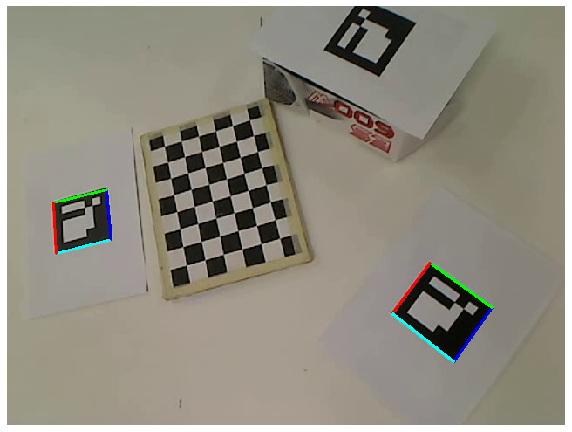

In [133]:
frame = frames[374].copy()
corners = find_corners(frame, 0.15)

from time import time
start = time()
pts = seek_targets(frame, corners, 50, 40, 5)
end = time()

print('Demorou:', end-start, 'segundos')
show(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

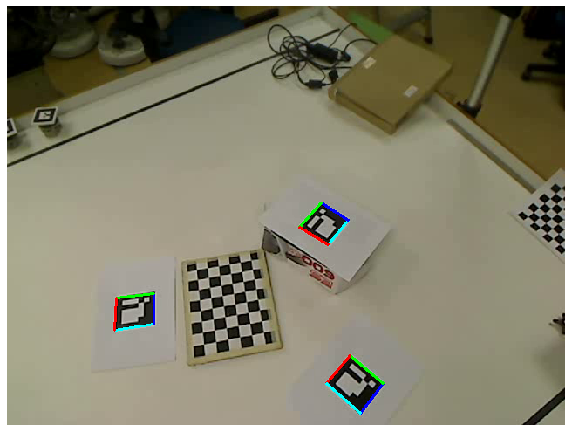

In [59]:
pts1 = np.array([[406, 465], [431, 433], [394, 401], [366, 433]])
pts2 = np.array([[368, 274], [392, 245], [360, 226], [336, 253]])
pts3 = np.array([(124, 371), (168, 365), (168, 328), (125, 334)])

# target_points = []
# target_points.append(pts1)
# target_points.append(pts2)
# target_points.append(pts3)

target_points = pts

frame = frames[1].copy()
corners = find_corners(frame, 0.01)
scan_optimized(frame, corners, target_points)

show(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [51]:
selected = frames[:500].copy()

In [ ]:
corners = find_corners(selected[0], 0.1)

In [ ]:
# seek_targets(selected[0], corners)

In [ ]:
target_pts = [
    [(405, 468), (431, 433), (394, 401), (366, 433)],
    [(124, 371), (168, 365), (168, 328), (126, 334)],
    [(368, 274), (391, 245), (360, 226), (336, 253)]
]

target_pts = scan_optimized(selected[0], corners, target_pts)
print(target_pts)
show(cv2.cvtColor(selected[0], cv2.COLOR_BGR2RGB))

In [147]:
selected = frames[:500].copy()
# target_pts = [
#     [(405, 468), (431, 433), (394, 401), (366, 433)],
#     [(124, 371), (168, 365), (168, 328), (126, 334)],
#     [(368, 274), (391, 245), (360, 226), (336, 253)]
# ]

target_pts = []

for i, frame in enumerate(selected):
    corners = find_corners(frame, 0.01)
    target_pts = scan_optimized(frame, corners, target_pts)
    print('Scan_optimized achou', len(target_pts), 'alvos')
    
    print('Analisando o frame', i+1)
    
    if len(target_pts) < 3:
        corners = find_corners(frame, 0.15)
        
#         if len(target_pts) != 0:
#             for pts in target_points:
#                 for p in pts:
#                     remove_neighbors(p[0], p[1], corners)
#                 corners = list(filter(lambda e: out_target(pts, e), corners))
            
        target_pts = seek_targets(frame, corners, 50, 10, 10, abs(3 - len(target_pts)))
        if len(target_pts) <= 2:
            print('Entrei aqui')
            target_pts = seek_targets(frame, corners, 50, 40, 5, abs(3 - len(target_pts)))
            
        print('Seek achou', len(target_pts), 'alvos')

Scan_optimized achou 0 alvos
Analisando o frame 1
Seek achou 3 alvos
Scan_optimized achou 3 alvos
Analisando o frame 2
Scan_optimized achou 3 alvos
Analisando o frame 3
Scan_optimized achou 3 alvos
Analisando o frame 4
Scan_optimized achou 3 alvos
Analisando o frame 5
Scan_optimized achou 3 alvos
Analisando o frame 6
Scan_optimized achou 3 alvos
Analisando o frame 7
Scan_optimized achou 3 alvos
Analisando o frame 8
Scan_optimized achou 3 alvos
Analisando o frame 9
Scan_optimized achou 3 alvos
Analisando o frame 10
Scan_optimized achou 3 alvos
Analisando o frame 11
Scan_optimized achou 3 alvos
Analisando o frame 12
Scan_optimized achou 3 alvos
Analisando o frame 13
Scan_optimized achou 3 alvos
Analisando o frame 14
Scan_optimized achou 3 alvos
Analisando o frame 15
Scan_optimized achou 3 alvos
Analisando o frame 16
Scan_optimized achou 3 alvos
Analisando o frame 17
Scan_optimized achou 3 alvos
Analisando o frame 18
Scan_optimized achou 3 alvos
Analisando o frame 19
Scan_optimized achou 

Scan_optimized achou 3 alvos
Analisando o frame 162
Scan_optimized achou 3 alvos
Analisando o frame 163
Scan_optimized achou 3 alvos
Analisando o frame 164
Scan_optimized achou 3 alvos
Analisando o frame 165
Scan_optimized achou 3 alvos
Analisando o frame 166
Scan_optimized achou 3 alvos
Analisando o frame 167
Scan_optimized achou 3 alvos
Analisando o frame 168
Scan_optimized achou 3 alvos
Analisando o frame 169
Scan_optimized achou 3 alvos
Analisando o frame 170
Scan_optimized achou 3 alvos
Analisando o frame 171
Scan_optimized achou 3 alvos
Analisando o frame 172
Scan_optimized achou 3 alvos
Analisando o frame 173
Scan_optimized achou 3 alvos
Analisando o frame 174
Scan_optimized achou 3 alvos
Analisando o frame 175
Scan_optimized achou 3 alvos
Analisando o frame 176
Scan_optimized achou 3 alvos
Analisando o frame 177
Scan_optimized achou 3 alvos
Analisando o frame 178
Scan_optimized achou 3 alvos
Analisando o frame 179
Scan_optimized achou 3 alvos
Analisando o frame 180
Scan_optimiz

Scan_optimized achou 3 alvos
Analisando o frame 321
Scan_optimized achou 3 alvos
Analisando o frame 322
Scan_optimized achou 3 alvos
Analisando o frame 323
Scan_optimized achou 3 alvos
Analisando o frame 324
Scan_optimized achou 3 alvos
Analisando o frame 325
Scan_optimized achou 3 alvos
Analisando o frame 326
Scan_optimized achou 3 alvos
Analisando o frame 327
Scan_optimized achou 3 alvos
Analisando o frame 328
Scan_optimized achou 3 alvos
Analisando o frame 329
Scan_optimized achou 3 alvos
Analisando o frame 330
Scan_optimized achou 3 alvos
Analisando o frame 331
Scan_optimized achou 3 alvos
Analisando o frame 332
Scan_optimized achou 3 alvos
Analisando o frame 333
Scan_optimized achou 3 alvos
Analisando o frame 334
Scan_optimized achou 3 alvos
Analisando o frame 335
Scan_optimized achou 3 alvos
Analisando o frame 336
Scan_optimized achou 3 alvos
Analisando o frame 337
Scan_optimized achou 3 alvos
Analisando o frame 338
Scan_optimized achou 3 alvos
Analisando o frame 339
Scan_optimiz

KeyboardInterrupt: 

In [138]:
for frame in selected:
    cv2.imshow('Teste', frame)
    if cv2.waitKey(50) == 27:
        print('*** Video stopped by user ***')
        break
        
cap.release()
cv2.destroyAllWindows()